In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import table
import subprocess
from scipy.optimize import curve_fit

## Load Data and display tabke

In [2]:
df = pd.read_excel('Hg.xlsx')
df

,order,direction,lambda,degree eyepiece,arcminute eyepiece,degree inlet,arcminute inlet,uncertainty,zero
0,1,1,404.66,14,3,194,2,1,1.5
1,1,1,435.84,15,10,195,8,1,1.5
2,1,1,576.96,20,14,200,13,1,1.5
3,1,1,578.97,20,18,200,18,1,1.5
4,2,1,435.84,31,31,211,30,1,1.5
5,2,1,546.07,40,55,220,55,1,1.5
6,2,1,576.96,43,48,223,48,1,1.5
7,3,1,435.84,51,40,231,36,1,1.5
8,1,-1,404.66,345,58,165,55,1,1.5
9,1,-1,435.84,344,50,164,48,1,1.5


## Send table to an array and transpose it for easy indexing, then pull out all the necessary attributes

In [3]:
arr = df.values.T
eye_d = arr[3]
eye_m = arr[4]
in_d = arr[5]
in_m = arr[6]
orders = arr[0]
lambdas = arr[2]
directions = arr[1]
zero = -1*arr[8]
uncertainties = arr[7]

## Add the zero to the minutes and then convert to degrees from arcminutes

In [4]:
eye_m += zero*directions
in_m += zero*directions
eye_m = eye_m/60
in_m = in_m/60

## Add the converted arcminutes to the degrees

In [5]:
eye_d += eye_m
in_d += in_m

## Find the differences and average the readings from both verniers output which measurements need to be reconsidered

In [6]:
diff = eye_d - (in_d-180)%360
bools = diff>10**(-6)
print('there are {} measurements to recheck, check the arrays for the wavelength and order'.format(np.sum(bools)))
wl = lambdas[bools]
order = orders[bools]
direction = directions[bools]
print(wl)
print(order)
print(direction)
print(eye_d[bools], (in_d[bools]-180)%360)
# for indexing the fit
indices = np.invert(bools)

there are 14 measurements to recheck, check the arrays for the wavelength and order
[404.66 435.84 576.96 435.84 435.84 404.66 435.84 546.07 576.96 578.97
 435.84 546.07 576.96 435.84]
[1. 1. 1. 2. 3. 1. 1. 1. 1. 1. 2. 2. 2. 3.]
[ 1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[ 14.025       15.14166667  20.20833333  31.49166667  51.64166667
 345.99166667 344.85833333 340.90833333 339.775      339.69166667
 328.525      319.10833333 316.225      308.35833333] [ 14.00833333  15.10833333  20.19166667  31.475       51.575
 345.94166667 344.825      340.85833333 339.725      339.64166667
 328.475      319.05833333 316.175      308.34166667]


In [7]:
average = (eye_d + (in_d-180)%360)/2
average[average>178] -= 360
print(np.deg2rad(average))

[ 0.24463698  0.26398105  0.35255651  0.35386551  0.54948783  0.71369422
  0.76401788  0.90073534 -0.24492787 -0.26456283 -0.33364878 -0.35342917
 -0.35488361 -0.54977871 -0.71413055 -0.76445421 -0.90146256]


## Now we do a least squares fit given by the following equation

$$ n_k\lambda_k = d(\sin\theta_i \pm \sin(\theta_k\pm\theta_i)) $$

## To determine $d^{-1}$ and $sin\theta_i$

In [8]:
def f(x, d, thi):
    # could be + or - for where these are
    return d*(np.sin(thi)+np.sin(x-thi))

def f_err(x,d,thi,xerr,derr,thierr):
    return (d*np.cos(x-thi)*xerr)**2 + ((np.sin(thi)+np.sin(x-thi))*derr)**2 + (d*(np.cos(thi)-np.cos(x-thi))*thierr)**2

def chi_squared(exp, th, err):
    if len(exp) != len(th):
        raise ValueError('dimensions do not match')
        
    return {'theoretical_chi_2':len(exp), 'chi2_deviation':np.sqrt(2*len(exp)), 'calculated_chi2':np.sum((exp-th)**2/err)}

<ErrorbarContainer object of 3 artists>

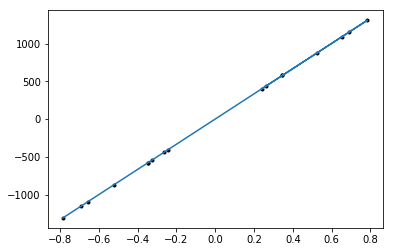

In [9]:
outs = lambdas*orders*directions
ins = np.deg2rad(average)
init = [1/600*10**(6), 0.01]
params, cov = curve_fit(f, ins, outs, p0=init)

d = params[0]
derr = np.sqrt(cov[0,0])
thierr = np.sqrt(cov[1,1])
thi = params[1]
xerr = np.deg2rad(1/60)

err = f_err(ins,d,thi,xerr,derr,thierr)
plt.plot(np.sin(ins), outs, 'k.')
plt.errorbar(np.sin(ins), f(ins, d, thi), yerr=np.sqrt(err))

<ErrorbarContainer object of 3 artists>

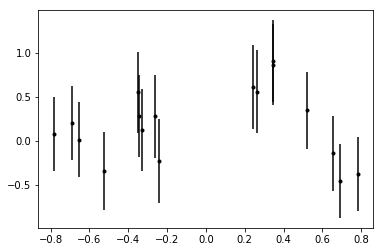

In [10]:
plt.errorbar(np.sin(ins), outs-f(ins,d,thi), yerr=np.sqrt(err), fmt='.k')

In [11]:
chi2 = chi_squared(outs, f(ins,d,thi), err)
print(chi2)
res = np.abs(outs-f(ins,d,thi))
mean_res = np.mean(res)
max_res = np.amax(res)
print(res, mean_res, max_res)

{'theoretical_chi_2': 17, 'chi2_deviation': 5.830951894845301, 'calculated_chi2': 16.491008851623306}
[0.61548447 0.560568   0.90779305 0.86851417 0.34782966 0.14023379
 0.45324568 0.37748041 0.22716367 0.2801681  0.12095591 0.28760066
 0.55238988 0.34132543 0.01511999 0.20974371 0.08182857] 0.375732066544836 0.9077930471892159


<ErrorbarContainer object of 3 artists>

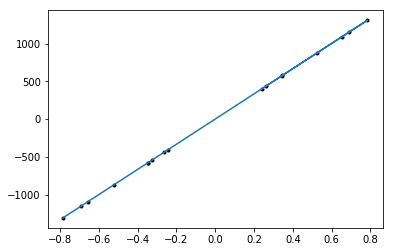

In [12]:
outs = lambdas*orders*directions
ins = np.deg2rad(average)
init = [1/600*10**(6), 0.01]
params, cov = curve_fit(f, ins, outs, p0=init, sigma=1/err)

d = params[0]
derr = np.sqrt(cov[0,0])
thierr = np.sqrt(cov[1,1])
thi = params[1]
xerr = np.deg2rad(1/60)

err = f_err(ins,d,thi,xerr,derr,thierr)
plt.plot(np.sin(ins), outs, 'k.')
plt.errorbar(np.sin(ins), f(ins, d, thi), yerr=np.sqrt(err))

Text(0.5, 0, '$\\sin\\theta$')

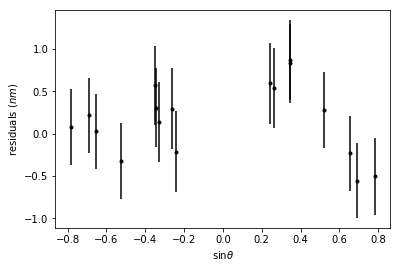

In [13]:
plt.errorbar(np.sin(ins), outs-f(ins,d,thi), yerr=np.sqrt(err), fmt='.k')
plt.ylabel(r'residuals $(nm)$')
plt.xlabel(r'$\sin\theta$')
#plt.savefig('bad_residuals.png')

In [14]:
chi2 = chi_squared(outs, f(ins,d,thi), err)
print(chi2)
res = np.abs(outs-f(ins,d,thi))
mean_res = np.mean(res)
max_res = np.amax(res)
print(res, mean_res, max_res)

{'theoretical_chi_2': 17, 'chi2_deviation': 5.830951894845301, 'calculated_chi2': 16.390629611528606}
[0.59154522 0.53434541 0.87044735 0.83099614 0.28220106 0.23254526
 0.55418127 0.50264842 0.21326501 0.29471545 0.13722246 0.30419712
 0.56900774 0.32539452 0.02502718 0.2168324  0.07901198] 0.3860931763245336 0.8704473500172298


In [15]:
df1 = pd.read_excel('Hydrogen.xlsx')
df1

,order,orientation,lambda,degree eyepiece,arcminute eyepiece,degree inlet,arcminute inlet,uncertainty,zero
0,1,1,434.05,15,4,195,3,1,1.5
1,1,1,486.13,16,55,196,53,1,1.5
2,1,1,656.30,23,10,203,7,1,1.5
3,2,1,434.05,31,20,211,17,1,1.5
4,2,1,486.13,35,40,215,36,1,1.5
5,2,1,656.30,51,57,231,53,1,1.5
6,1,-1,434.05,344,55,154,51,1,1.5
7,1,-1,486.13,343,2,162,58,1,1.5
8,1,-1,656.30,336,48,156,43,1,1.5
9,2,-1,434.05,328,37,148,33,1,1.5


In [16]:
arr1 = df1.values.T
eye_d = arr1[3]
eye_m = arr1[4]
in_d = arr1[5]
in_m = arr1[6]
orders = arr1[0]
lambdas = arr1[2]
directions = arr1[1]
zero = -1*arr1[8]
uncertainties = arr1[7]

In [17]:
eye_m += zero*directions
in_m += zero*directions
eye_m = eye_m/60
in_m = in_m/60

In [18]:
eye_d += eye_m
in_d += in_m

In [19]:
diff = eye_d - (in_d-180)%360
bools = diff>10**(-6)
print('there are {} measurements to recheck, check the arrays for the wavelength and order'.format(np.sum(bools)))
wl = lambdas[bools]
order = orders[bools]
direction = directions[bools]
print(wl)
print(order)
print(direction)
print(eye_d[bools], (in_d[bools]-180)%360)
# for indexing the fit
indices = np.invert(bools)

there are 12 measurements to recheck, check the arrays for the wavelength and order
[434.05 486.13 656.3  434.05 486.13 656.3  434.05 486.13 656.3  434.05
 486.13 656.3 ]
[1. 1. 1. 2. 2. 2. 1. 1. 1. 2. 2. 2.]
[ 1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.]
[ 15.04166667  16.89166667  23.14166667  31.30833333  35.64166667
  51.925      344.94166667 343.05833333 336.825      328.64166667
 324.325      308.10833333] [ 15.025       16.85833333  23.09166667  31.25833333  35.575
  51.85833333 334.875      342.99166667 336.74166667 328.575
 324.225      308.025     ]


In [20]:
average = (eye_d + (in_d-180)%360)/2
average[average>178] -= 360
print(np.deg2rad(average))

[ 0.26238116  0.29452431  0.40346195  0.54599717  0.62148266  0.90568044
 -0.35066574 -0.29626964 -0.40520727 -0.54788794 -0.62351888 -0.90640766]


In [21]:
ins = np.deg2rad(average)

wls = f(ins, d, thi)/orders*directions
print(wls)
wl_uncertainties = np.sqrt(f_err(ins,d,thi,xerr,derr,thierr))
print(wl_uncertainties)

[432.72812381 484.29252754 655.030914   433.21202619 485.7651912
 656.567772   572.93868763 486.94343584 657.45736733 434.33267136
 486.85395328 656.34757153]
[0.47406109 0.47138893 0.46119867 0.44783994 0.44248188 0.45245744
 0.46603186 0.47100074 0.46074015 0.44738869 0.44210122 0.45264794]


In [22]:
data_dict = {'orders':orders, 'theoretical wavelengths':lambdas,'experimental wavelengths':wls, 'uncertainties':wl_uncertainties}

In [23]:
hydrogen = pd.DataFrame(data_dict)

In [24]:
hydrogen

,orders,theoretical wavelengths,experimental wavelengths,uncertainties
0,1.0,434.05,432.728124,0.474061
1,1.0,486.13,484.292528,0.471389
2,1.0,656.30,655.030914,0.461199
3,2.0,434.05,433.212026,0.447840
4,2.0,486.13,485.765191,0.442482
5,2.0,656.30,656.567772,0.452457
6,1.0,434.05,572.938688,0.466032
7,1.0,486.13,486.943436,0.471001
8,1.0,656.30,657.457367,0.460740
9,2.0,434.05,434.332671,0.447389


In [25]:
hydrogen = hydrogen.drop(hydrogen.index[[6]])

In [26]:
hydrogen

,orders,theoretical wavelengths,experimental wavelengths,uncertainties
0,1.0,434.05,432.728124,0.474061
1,1.0,486.13,484.292528,0.471389
2,1.0,656.30,655.030914,0.461199
3,2.0,434.05,433.212026,0.447840
4,2.0,486.13,485.765191,0.442482
5,2.0,656.30,656.567772,0.452457
7,1.0,486.13,486.943436,0.471001
8,1.0,656.30,657.457367,0.460740
9,2.0,434.05,434.332671,0.447389
10,2.0,486.13,486.853953,0.442101


In [27]:
data = hydrogen.values.T
chi2 = chi_squared(data[1],data[2],data[3])

In [28]:
chi2

{'theoretical_chi_2': 11,
 'chi2_deviation': 4.69041575982343,
 'calculated_chi2': 22.048969041764845}